# Import Required Python Libraries

In [ ]:
# Import necessary libraries for numerical analysis, visualization, and statistical testing
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.stats import pearsonr

<ipython-input-1-2d733829a3e1>:5: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


# Read Dataset and Process Spikes, Trials and Behavious

In [ ]:
# Load the dataset from a text file into a NumPy array
dataset_name = 'DataSetCoursework_KHA'
data = np.loadtxt(dataset_name + '.txt')

# Print the shape of the loaded data (number of rows and columns)
print('Data Shape :', data.shape)

# Extract the trials and behaviors from the last two columns of the data
trials = data[:, -1]  # All rows, last column
behaviours = data[:, -2]  # All rows, second-to-last column

# Print a separator for visual clarity
print('-----------------' * 4, '\nSpikes\n')

# Extract the spike data from all columns except the last two
spikes = data[:, :-2]  # All rows, all columns except the last two

# Print the spike data
print(spikes)

# Print the shape of the spike data
print('\nSpikes Shape :', spikes.shape)

Data Shape : (2977, 8)
-------------------------------------------------------------------- 
Spikes

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]

Spikes Shape : (2977, 6)


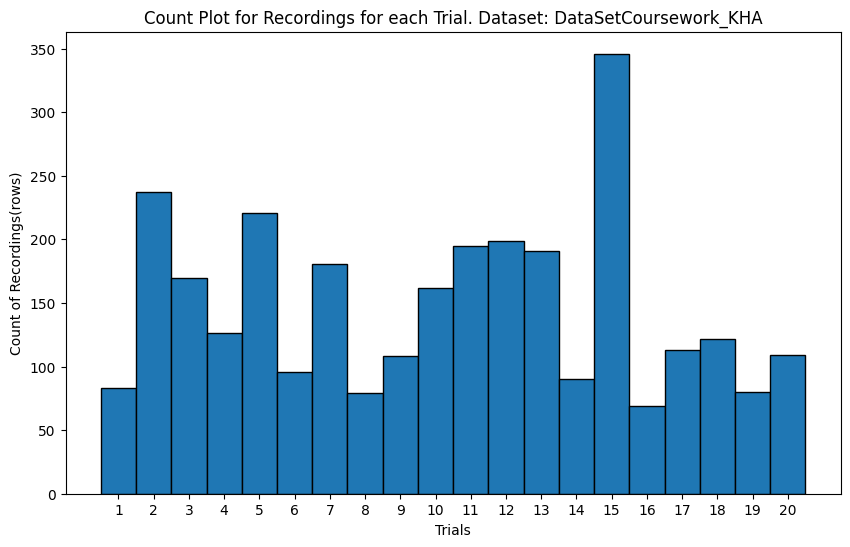

In [ ]:
# Create a histogram to visualize the distribution of recordings across trials
plt.figure(figsize=(10, 6))
plt.hist(trials, bins=np.arange(1, max(trials)+2) - 0.5, edgecolor='black')
plt.title('Count Plot for Recordings for each Trial. Dataset: '+dataset_name)
plt.xlabel('Trials')
plt.ylabel('Count of Recordings(rows)')
plt.xticks(np.arange(1, max(trials)+1))
plt.show()

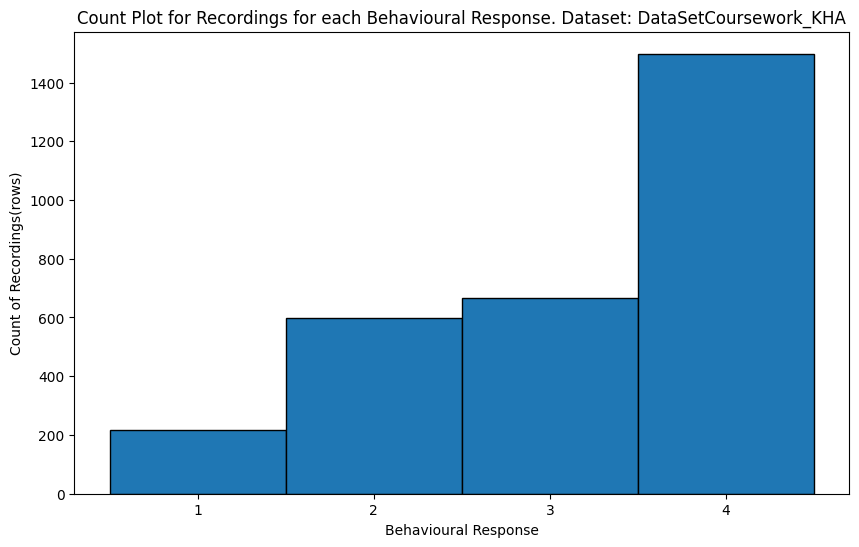

In [ ]:
# Visualize the distribution of recordings across behavioral responses using a histogram
plt.figure(figsize=(10, 6))
plt.hist(behaviours, bins=np.arange(1, max(behaviours)+2) - 0.5, edgecolor='black')
plt.title('Count Plot for Recordings for each Behavioural Response. Dataset: '+ dataset_name)
plt.xlabel('Behavioural Response')
plt.ylabel('Count of Recordings(rows)')
plt.xticks(np.arange(1, max(behaviours)+1))
plt.show()

# Ploting Spikes and Rates for all 6 Neurons

In [ ]:
def plot_data(times, spikes, rate, artificial_spikes):
    """
    Plots the spike trains and firing rates for multiple neurons.

    Args:
        times (array-like): Time values for the recordings.
        spikes (2D array): Spike data for each neuron, with shape (time steps, neurons).
        rate (2D array): Firing rate data for each neuron, with shape (time steps, neurons).
    """
    print('Spikes and Firing Rates plot for-'+dataset_name)
    # Create a figure with subplots for each neuron's spike train and firing rate
    fig, ax = plt.subplots(6, 2, figsize=(20, 20))
    m = len(spikes[0])  # Number of neurons

    if artificial_spikes:
      arti_prefix = 'Artificially generated '
    else:
      arti_prefix = ''

    # Plot spike trains for each neuron
    for i in range(m):
        ax[i, 0].set_title(f'{arti_prefix}Neuron {i + 1}')  # Set title for spike train plot
        ax[i, 0].plot(times, spikes[:, i])  # Plot spike train

    plt.xlabel('Time (s)')  # Set x-axis label for all spike train plots

    # Plot firing rates for each neuron
    for i in range(m):
        ax[i, 1].set_title(f'{arti_prefix}Neuron {i + 1} rate')  # Set title for firing rate plot
        ax[i, 1].plot(times, rate[:, i], 'r')  # Plot firing rate (red line)

    plt.xlabel('Time (s)')  # Set x-axis label for all firing rate plots
    fig.tight_layout()  # Adjust layout for better spacing
    plt.show()  # Display the plot

# Calculating Rates for each Neurons

Spikes and Firing Rates plot for-DataSetCoursework_KHA


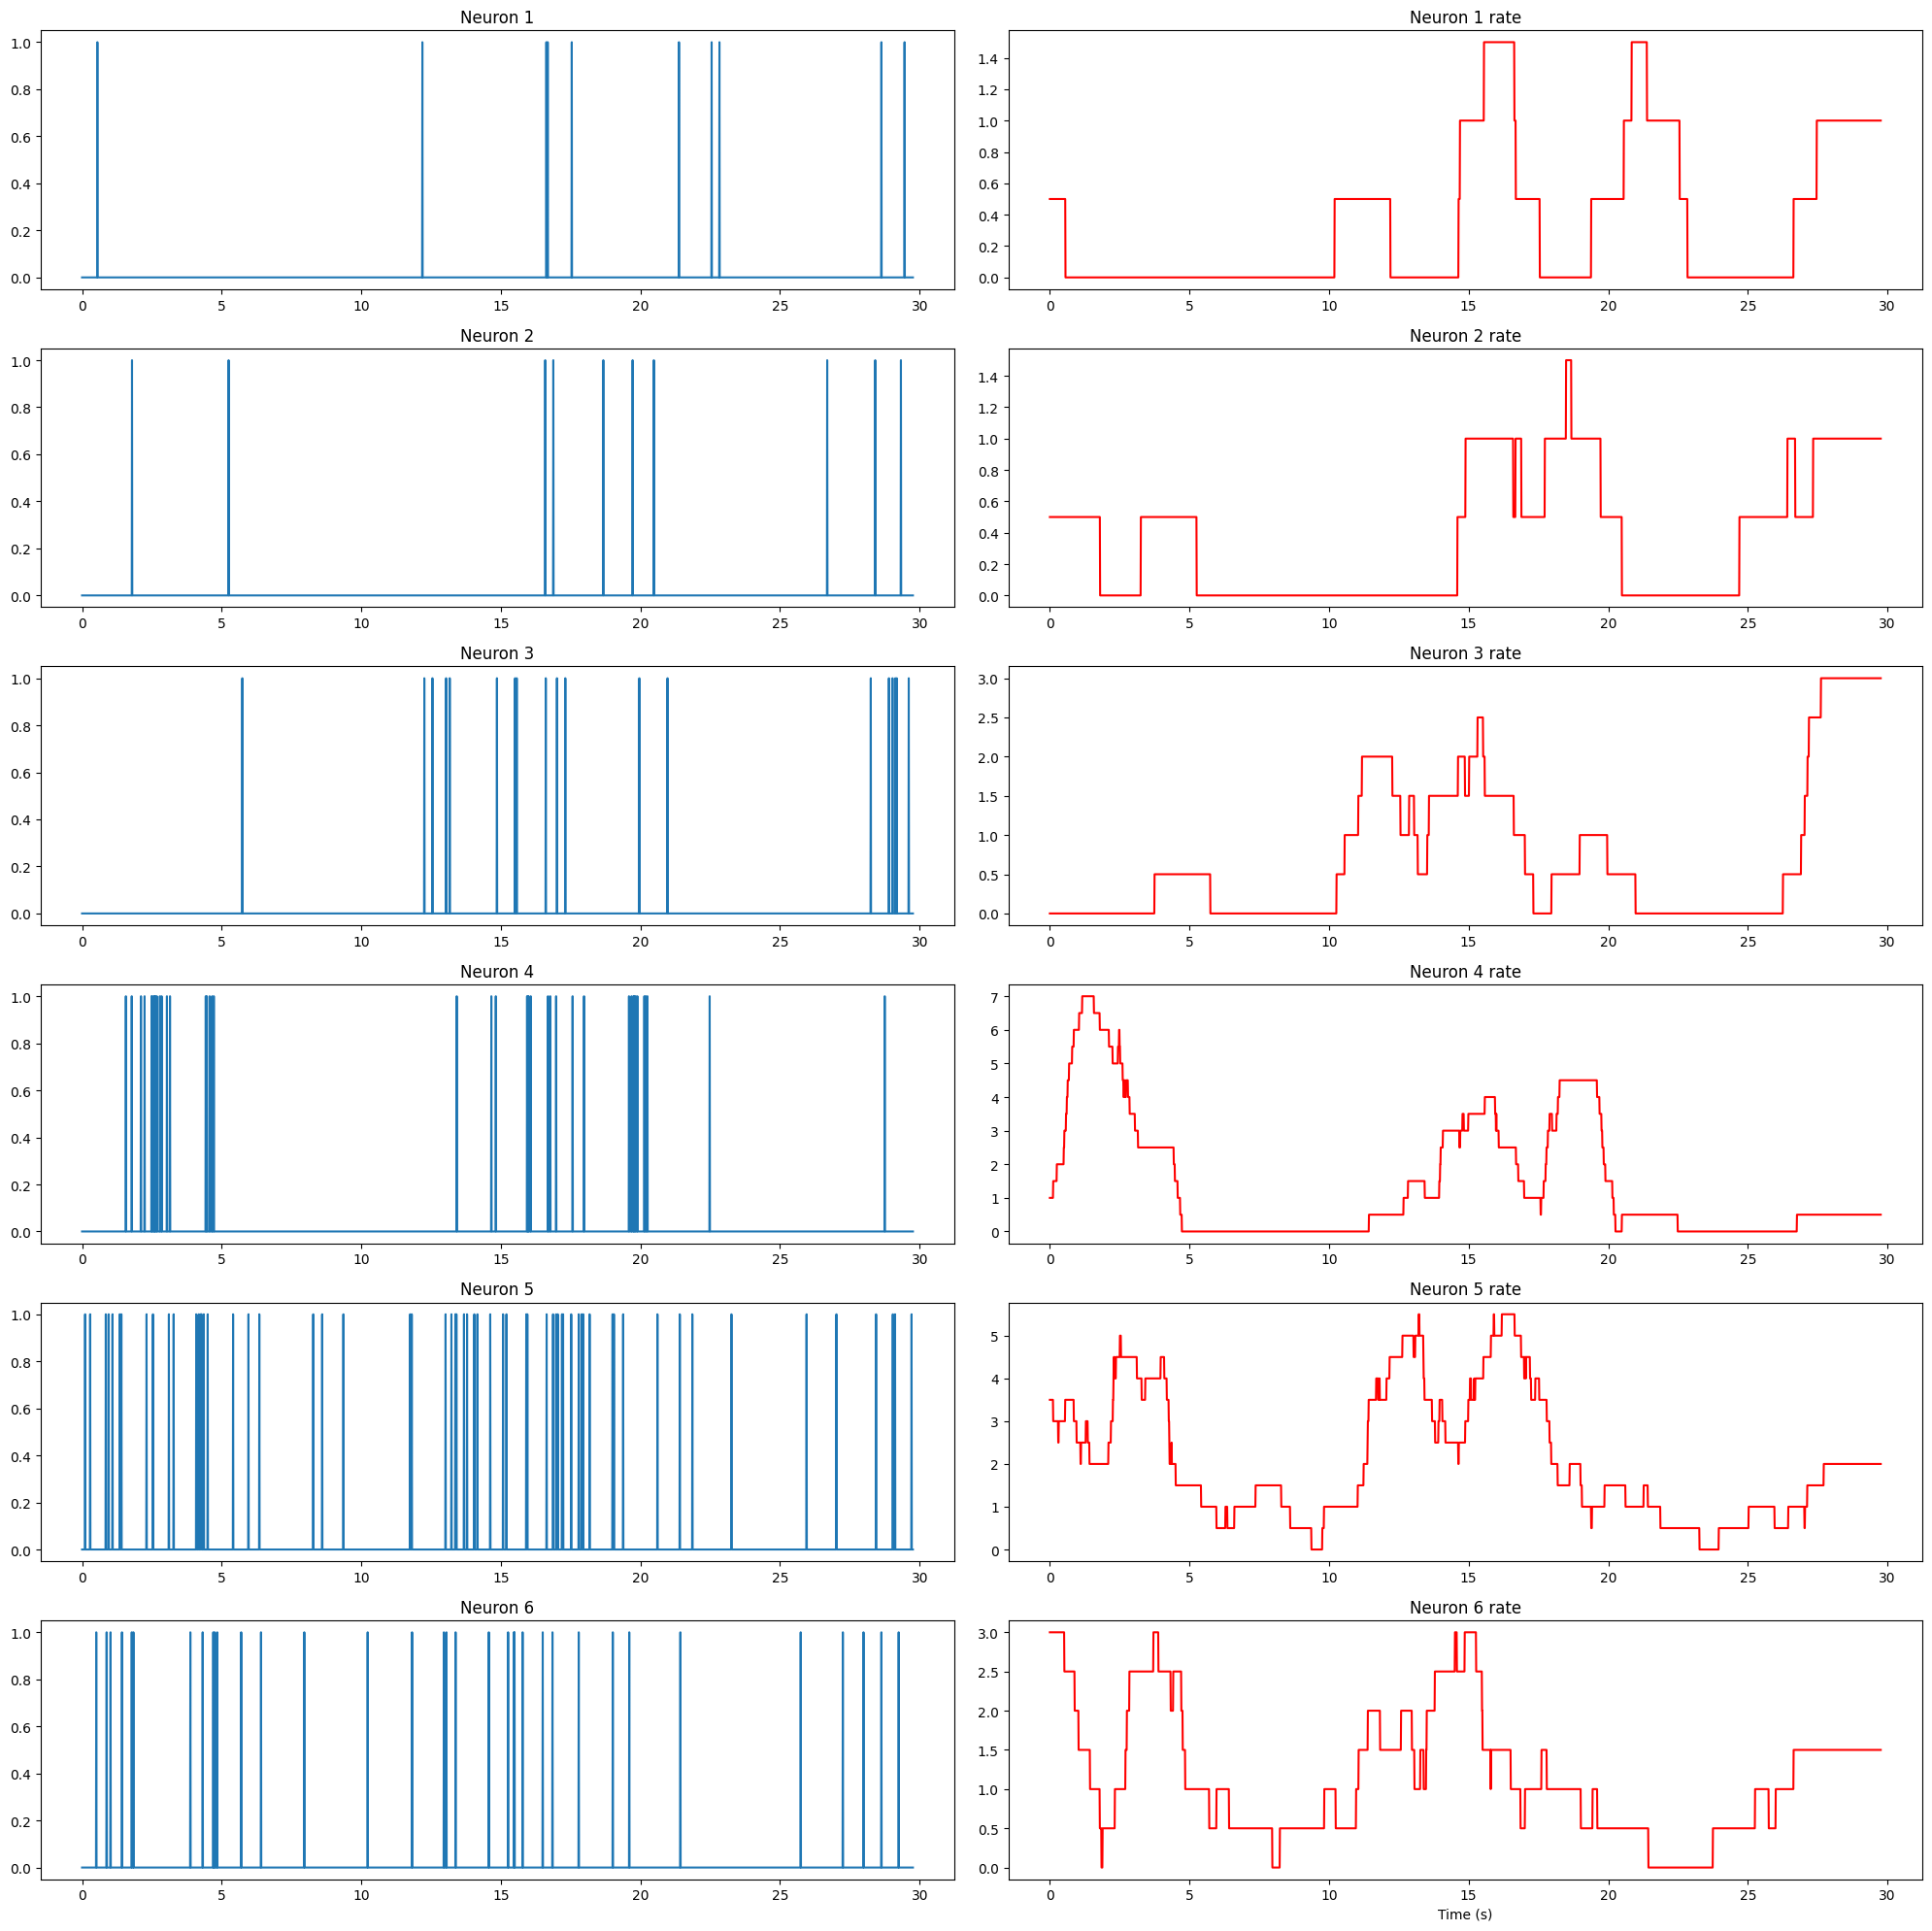

In [ ]:
def cal_rates(spikes, artificial_spikes=False, window_size=2, bin_size=0.01):
    """
    Calculates firing rates for each neuron using a sliding window approach.

    Args:
        spikes (2D array): Spike data for each neuron, with shape (time steps, neurons).
        window_size (float): Size of the sliding window in seconds (default: 2).
        bin_size (float): Time resolution for the spike data in seconds (default: 0.01).

    Returns:
        2D array: Firing rate data for each neuron, with shape (time steps, neurons + 1).
    """

    n, m = spikes.shape  # Get number of time steps and neurons

    # Create time array based on bin size
    times = np.arange(0, n * bin_size, bin_size)

    # Calculate number of time steps in the window
    window_steps = int(window_size / bin_size)

    # Initialize array to store firing rates
    rate = np.zeros((n, m))

    # Calculate firing rate for each neuron using a sliding window
    for j in range(m):
        smoothed = [np.sum(spikes[i:i + window_steps, j]) * (1 / window_size)
                    for i in range(n - window_steps + 1)]
        smoothed.extend([smoothed[-1]] * (window_steps - 1))  # Extend for initial window steps
        rate[:, j] = smoothed

    # Append the last spike column to the rate array
    rate = np.hstack((rate, spikes[:, -1].reshape(-1, 1)))

    # Plot the spike trains and firing rates
    plot_data(times, spikes, rate, artificial_spikes)

    return rate

# Calculate firing rates using the default parameters
rates = cal_rates(spikes)


# Calculating Pearsonr Correlation Coefficient for all 6 Neurons

In [ ]:
def print_correlation_coefficients(spikes, rates, trials):
    """
    Prints correlation coefficients between firing rates and spike counts for each neuron,
    calculated separately for each trial.

    Args:
        spikes (2D array): Spike data for each neuron, with shape (time steps, neurons).
        rates (2D array): Firing rate data for each neuron, with shape (time steps, neurons + 1).
        trials (array-like): Trial numbers for each time step.
    """

    m = len(spikes[0])  # Number of neurons

    print(f'CORRELATION COEFFICIENTS RATE vs SPIKES (p value). Significance: p<0.05. Dataset: {dataset_name}\n\n')

    for j in range(m):
        # Print header for each neuron
        print(f'\nCorrelation coef for Neuron {j + 1}. Dataset: {dataset_name}\n')

        # Create lists to store rates and spikes for each trial
        trail_rates = [[] for _ in range(20)]  # Assuming 20 trials
        trail_spikes = [[] for _ in range(20)]

        # Group rates and spikes by trial
        for rate, trial in zip(rates[:, j], trials):
            trail_rates[int(trial) - 1].append(rate)
        for spike, trial in zip(spikes[:, j], trials):
            trail_spikes[int(trial) - 1].append(spike)

        # Calculate correlation coefficients for each trial
        for index in range(20):
            corrcoef = pearsonr(trail_rates[index], trail_spikes[index])
            print(f'Trial {index + 1} \t ---- statistic: {corrcoef[0]} | pvalue: {corrcoef[1]}')

        print('---------------------------------------------------------------------------------\n')

# Print correlation coefficients for the given data
print_correlation_coefficients(spikes, rates, trials)


CORRELATION COEFFICIENTS RATE vs SPIKES (p value). Significance: p<0.05. Dataset: DataSetCoursework_KHA



Correlation coef for Neuron 1. Dataset: DataSetCoursework_KHA

Trial 1 	 ---- statistic: 0.07667979486648718 | pvalue: 0.4908188034795353
Trial 2 	 ---- statistic: nan | pvalue: nan
Trial 3 	 ---- statistic: nan | pvalue: nan
Trial 4 	 ---- statistic: nan | pvalue: nan
Trial 5 	 ---- statistic: nan | pvalue: nan
Trial 6 	 ---- statistic: nan | pvalue: nan
Trial 7 	 ---- statistic: nan | pvalue: nan
Trial 8 	 ---- statistic: nan | pvalue: nan
Trial 9 	 ---- statistic: 0.16744367165578405 | pvalue: 0.08325066412336612
Trial 10 	 ---- statistic: nan | pvalue: nan
Trial 11 	 ---- statistic: nan | pvalue: nan
Trial 12 	 ---- statistic: 0.25595545154954064 | pvalue: 0.00026334241481411206
Trial 13 	 ---- statistic: nan | pvalue: nan
Trial 14 	 ---- statistic: nan | pvalue: nan
Trial 15 	 ---- statistic: 0.12353013259062104 | pvalue: 0.02154543434426357
Trial 16 	 ---- statistic: nan | p

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


# Implementation of Leaky IF: Model for generating Artificial Spikes

In [ ]:
def LeakyIF_artificial_spikes(current_parameters=None, dur=0.2, delta_t=0.0001):

    """
    Simulates a leaky IF neuron model which uses adaptive threshold,
    optional excitatory and inhibitory post-synaptic currents (excitatory_psc and inhibitory_psc),
    background current, and refractory period.

    Args:
        current_parameters (dict, optional): Dictionary containing current parameters,
            with keys 'excitatory_psc' (list of excitatory PSC times),
            'inhibitory_psc' (list of inhibitory PSC times),
            'u0' (initial voltage), and 'i0' (initial current). Defaults to None.
        dur (float, optional): Simulation duration in seconds. Defaults to 0.2.
        delta_t (float, optional): Time step in seconds. Defaults to 0.0001.

    Returns:
        tuple: A tuple containing two arrays:
            - spike_time (array-like): Time values for the simulation.
            - adaptive_threshold (array-like): Adaptive threshold values over time.
    """

    # Fixed parameters
    membrane_constant = 0.020  # Membrane time constant (in seconds)
    resistance = 3e7  # Membrane resistance (in ohms)
    rest_potential = -0.07  # Resting membrane potential (in volts)
    depol_threshold = -0.030  # Depolarization threshold for spike detection (in volts)
    spike_voltage = 0.1  # Voltage value when a spike occurs (in volts)

    # Initialize parameters or use default values
    if current_parameters is None:
        initial_voltage = 0.3
        initial_current = initial_voltage / resistance
        excitatory_psc = np.arange(0, delta_t, delta_t)
    else:
        excitatory_psc = current_parameters.get('excitatory_psc', np.arange(0, delta_t, delta_t))
        initial_voltage = current_parameters.get('u0', 0.3)
        initial_current = current_parameters.get('i0', initial_voltage / resistance)

    T = dur
    refractory_period = 0.007  # Refractory period after a spike (in seconds)
    background_current = 3e-9  # Amplitude of the background current (in amperes)
    membrane_constant_adaptive = 0.3  # Time constant for adaptive threshold (in seconds)
    increase_threshold = 0.012  # Increase in threshold after a spike (in volts)

    # Check for inhibitory_psc in current_parameters
    if current_parameters is None or 'inhibitory_psc' not in current_parameters:
        inhibitory_psc = []
    else:
        inhibitory_psc = current_parameters.get('inhibitory_psc', [])

    # Initialization
    excitatory_psc_count = len(excitatory_psc)
    inhibitory_psc_count = len(inhibitory_psc)
    excitatory_psc_index = np.round(np.array(excitatory_psc) / delta_t).astype(int)
    inhibitory_psc_index = np.round(np.array(inhibitory_psc) / delta_t).astype(int)
    steps_count = int(T / delta_t)
    voltage = np.zeros(steps_count + 1)
    voltage_plot = np.zeros(steps_count + 1)
    voltage[0] = rest_potential
    voltage_plot[0] = rest_potential
    current = np.zeros(steps_count + 1)
    total_spike = 0
    spikes_count = 0
    spike_time = np.linspace(0, T, steps_count + 1)
    random_distribution = background_current * np.random.normal(0, 1, steps_count)

    adaptive_threshold = np.full(steps_count + 1, depol_threshold)

    # Simulation
    for step in range(steps_count):
        # Apply excitatory currents at specified times
        for excitatory_index in range(excitatory_psc_count):
            if step == excitatory_psc_index[excitatory_index]:
                current[step] += initial_current

        # Apply inhibitory currents at specified times
        for inhibitory_index in range(inhibitory_psc_count):
            if step == inhibitory_psc_index[inhibitory_index]:
                current[step] -= initial_current

        # Calculate change in voltage (du) using leaky integrate-and-fire equation
        du = (delta_t / membrane_constant) * (rest_potential - voltage[step] + current[step] * resistance + random_distribution[step] * resistance)

        # Update voltage for the next time step
        voltage[step + 1] = du + voltage[step]
        voltage_plot[step + 1] = voltage[step + 1]

        # Spike detection
        if voltage[step + 1] > adaptive_threshold[step]:
            if spikes_count > 0:
                if spike_time[step] >= (total_spike + refractory_period):
                    # Generate a spike if conditions are met
                    voltage_plot[step + 1] = spike_voltage
                    voltage[step + 1] = rest_potential
                    total_spike = spike_time[step]
                    spikes_count += 1
                    adaptive_threshold[step + 1] = adaptive_threshold[step] + increase_threshold
                else:
                    # Maintain resting state and update adaptive threshold
                    voltage[step + 1] = voltage[step]
                    voltage_plot[step + 1] = voltage[step + 1]
                    adaptive_threshold[step + 1] = adaptive_threshold[step] + (delta_t / membrane_constant_adaptive) * (depol_threshold - adaptive_threshold[step])
            else:
                # Generate a spike if conditions are met (no refractory period for the first spike)
                voltage_plot[step + 1] = spike_voltage
                voltage[step + 1] = rest_potential
                total_spike = spike_time[step]
                spikes_count += 1
                adaptive_threshold[step + 1] = adaptive_threshold[step] + increase_threshold
        else:
            # Update adaptive threshold if no spike is generated
            adaptive_threshold[step + 1] = adaptive_threshold[step] + (delta_t / membrane_constant_adaptive) * (depol_threshold - adaptive_threshold[step])

    # Plotting
    plt.figure()
    plt.plot(spike_time, voltage_plot, color='black')
    plt.axhline(y=depol_threshold, color='red', linestyle='--')
    plt.title('Simulation of Leaky I&F Neuron Model: \n Adaptive Threshold and Synaptic Currents. Dataset: '+dataset_name)
    plt.xlabel('Spike Time (s)')
    plt.ylabel(f'Voltage (U), Number of Spikes={spikes_count}')
    plt.grid(True)

    plt.figure()
    plt.plot(spike_time, adaptive_threshold, color='red')
    plt.axhline(y=depol_threshold, color='red', linestyle='--')
    plt.title(f'Resting-Threshold: {depol_threshold * 1000} mV, \n Refractory-Period: {refractory_period * 1000} msec. Dataset: '+dataset_name)
    plt.xlabel('Spike Time (s)')
    plt.ylabel(f'Spike Threshold (U), \n Number of Spikes={spikes_count}')
    plt.grid(True)

    plt.show()

    return spike_time, adaptive_threshold

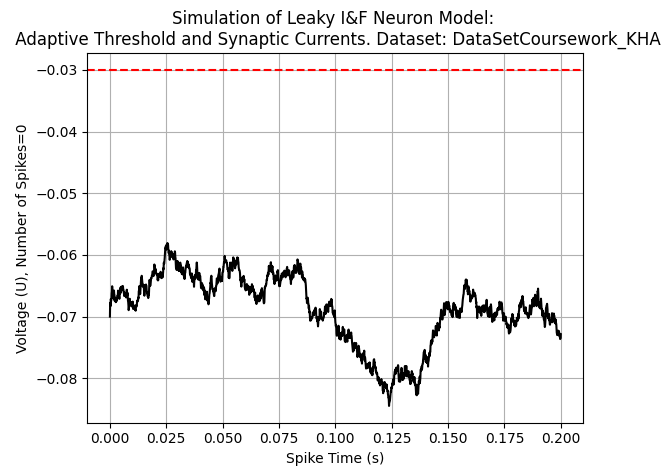

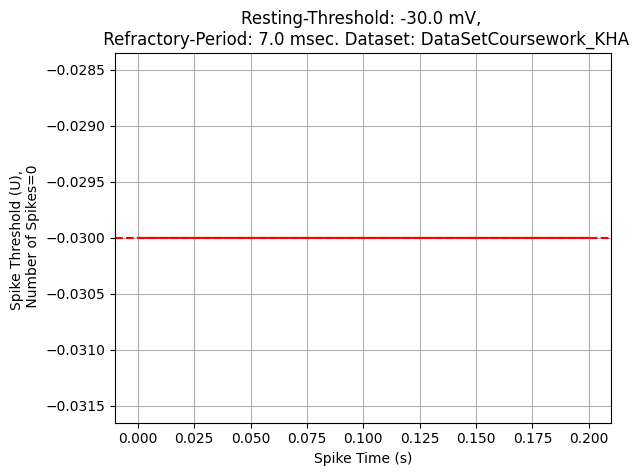

(array([0.000e+00, 1.000e-04, 2.000e-04, ..., 1.998e-01, 1.999e-01,
        2.000e-01]),
 array([-0.03, -0.03, -0.03, ..., -0.03, -0.03, -0.03]))

In [ ]:
# Executing Leaky model for default inputs
LeakyIF_artificial_spikes()

In [ ]:
def plot_artificial_spikes(time, theta_adapt, delta_t, dur):
  artificial_spikes_time = [round(t/delta_t) for t in time]
  artificial_spikes = [0]*(int(len(artificial_spikes_time)//10))
  count = 0
  for t in range(0,len(artificial_spikes_time), 10):

    for t_spike in range(0,10):
      if (t + t_spike < len(artificial_spikes_time)):
        if theta_adapt[t + t_spike]> theta_adapt[t + t_spike-1] and theta_adapt[t + t_spike]> theta_adapt[t + t_spike+1]:
          artificial_spikes[count] = 1

    count = count + 1

  times = np.arange(0, dur, 0.01)
  plt.figure(figsize=(10, 4))
  plt.plot(times, artificial_spikes[:])
  plt.title('Neuron Artificial Spikes. Dataset: '+dataset_name)
  plt.xlabel('Time (s)')
  plt.ylabel('Spikes')
  plt.show()

  return artificial_spikes

# Artificial Spikes for Neuron-1

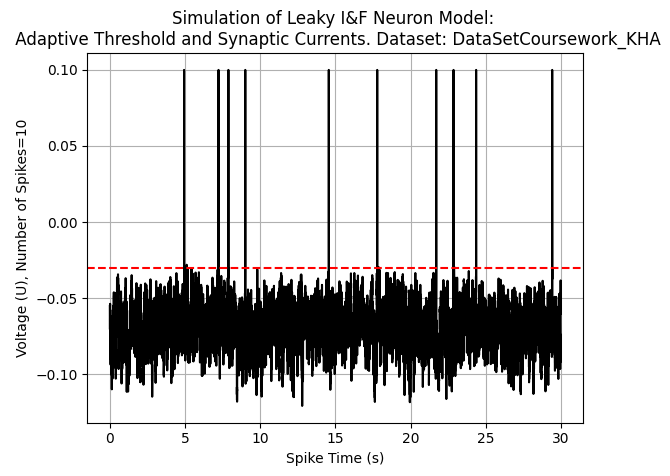

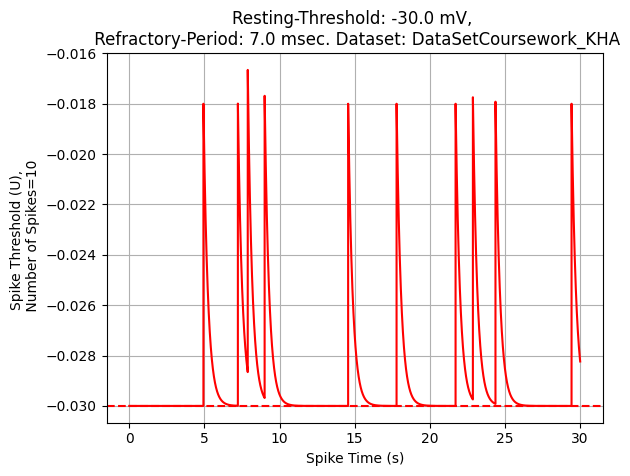

Adaptive Threshold:  [-0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03

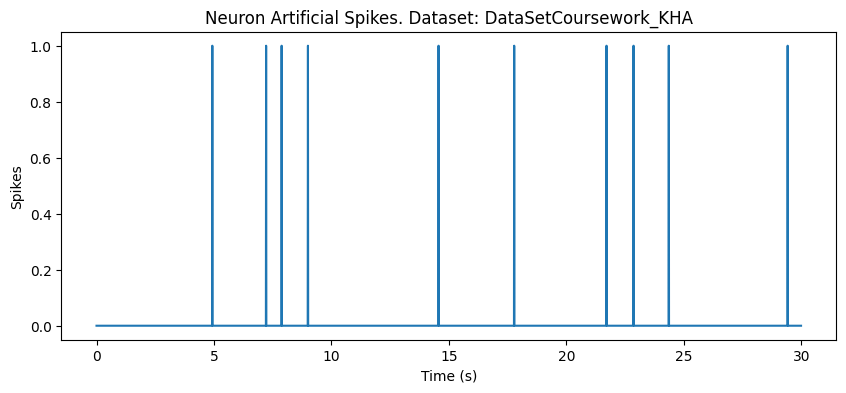

In [ ]:
# --- Generating post-synaptic currents from Neuron 1 ---

# Extract spike times from the first column of the 'spikes' array
spike_data = list(spikes[:, 0])

# Create a list to store PSC times
time = []

# Iterate through spike times and add corresponding times to 'time' list if a spike occurred
for spike_time in range(len(spike_data)):
    if spike_data[spike_time] != 0:
        time.append((spike_time + 1) * 0.01)  # Assuming time resolution of 0.01 seconds

# Prepare input currents dictionary
input_currents = {
    'psc': time,  # Excitatory post-synaptic current (PSC) times
    'U_0': 0.3,  # Reversal potential for PSCs
    'ipsc': np.array([0.03, 0.07]),  # Inhibitory post-synaptic current (IPSC) times
}

# --- Simulate the neuron model ---

# Call the leaky integrate-and-fire (LIF) model function to run the simulation
time, theta_adapt = LeakyIF_artificial_spikes(
    current_parameters=input_currents, dur=30, delta_t=0.001
)

# Print simulation results
print('Adaptive Threshold: ', list(theta_adapt))  # Print the adaptive threshold values over time
print('Artificial Spikes Time: ', list(time))  # Print the time values for the simulation

artificial_spike1 = plot_artificial_spikes(time, theta_adapt, 0.001, 30)


# Artificial Spikes for Neuron-2

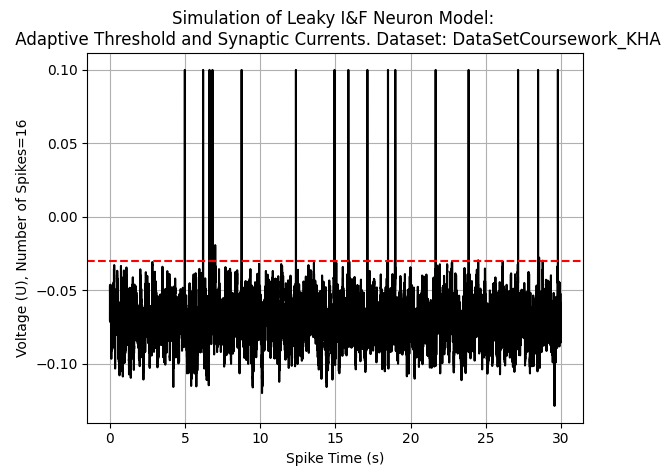

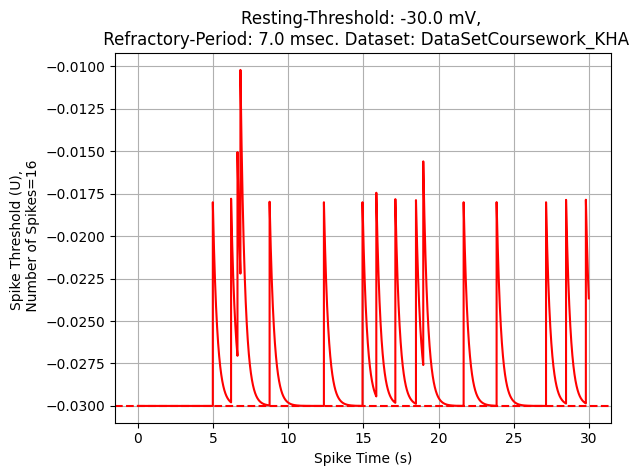

[-0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03

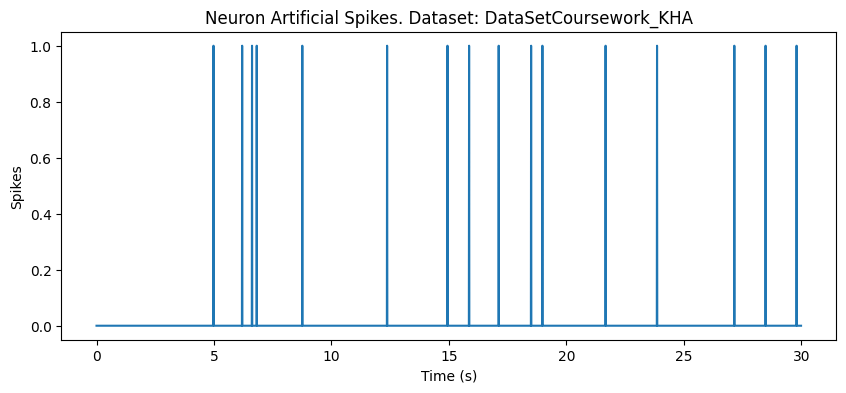

In [ ]:
# --- Generating post-synaptic currents from Neuron 2 ---

# Extract spike times from the second column of the 'spikes' array
spike_data = list(spikes[:, 1])

# Create a list to store PSC times
time = []

# Iterate through spike times and add corresponding times to 'time' list if a spike occurred
for spike_time in range(len(spike_data)):
    if spike_data[spike_time] != 0:
        time.append((spike_time + 1) * 0.01)  # Assuming time resolution of 0.01 seconds

# Prepare input currents dictionary
input_currents = {
    'psc': time,  # Excitatory post-synaptic current (PSC) times
    'U_0': 0.3,  # Reversal potential for PSCs
    'ipsc': np.array([0.03, 0.07]),  # Inhibitory post-synaptic current (IPSC) times
}

# --- Simulate the neuron model ---

# Call the leaky integrate-and-fire (LIF) model function to run the simulation
time, theta_adapt = LeakyIF_artificial_spikes(
    current_parameters=input_currents, dur=30, delta_t=0.001
)

# Print simulation results
print(list(theta_adapt))  # Print the adaptive threshold values over time
print(list(time))  # Print the time values for the simulation

artificial_spike2 = plot_artificial_spikes(time, theta_adapt, 0.001, 30)


# Artificial Spikes for Neuron-3

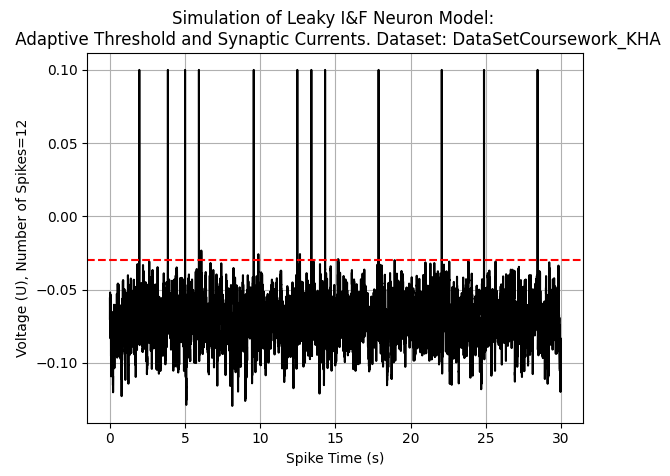

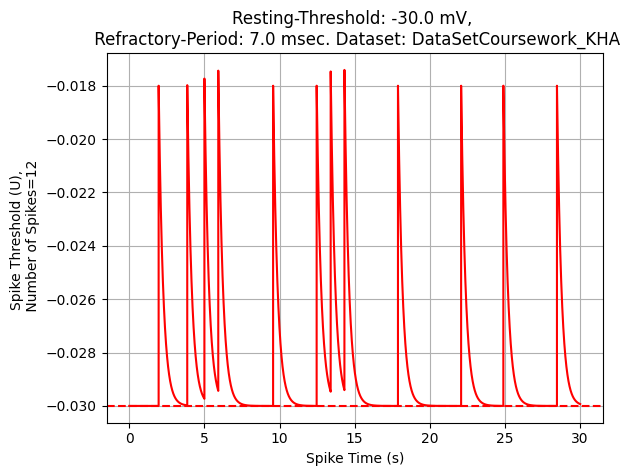

[-0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03

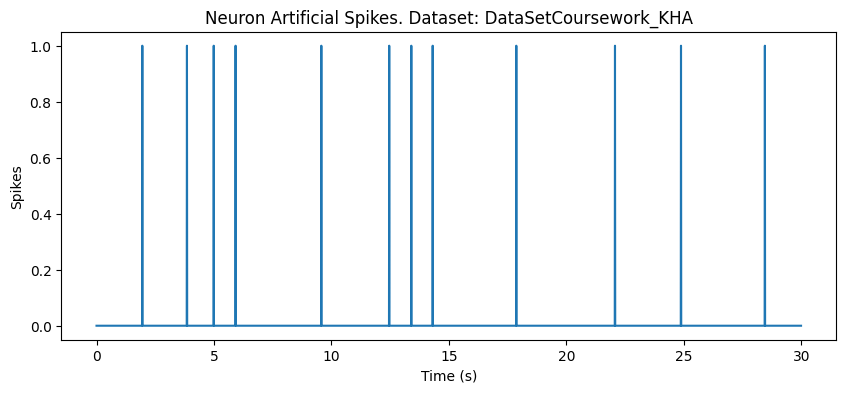

In [ ]:
# --- Generating post-synaptic currents from Neuron 3 ---

# Extract spike times from the third column of the 'spikes' array
spike_data = list(spikes[:, 0])

# Create a list to store PSC times
time = []

# Iterate through spike times and add corresponding times to 'time' list if a spike occurred
for spike_time in range(len(spike_data)):
    if spike_data[spike_time] != 0:
        time.append((spike_time + 1) * 0.01)  # Assuming time resolution of 0.01 seconds

# Prepare input currents dictionary
input_currents = {
    'psc': time,  # Excitatory post-synaptic current (PSC) times
    'U_0': 0.3,  # Reversal potential for PSCs
    'ipsc': np.array([0.03, 0.07]),  # Inhibitory post-synaptic current (IPSC) times
}

# --- Simulate the neuron model ---

# Call the leaky integrate-and-fire (LIF) model function to run the simulation
time, theta_adapt = LeakyIF_artificial_spikes(
    current_parameters=input_currents, dur=30, delta_t=0.001
)

# Print simulation results
print(list(theta_adapt))  # Print the adaptive threshold values over time
print(list(time))  # Print the time values for the simulation

artificial_spike3 = plot_artificial_spikes(time, theta_adapt, 0.001, 30)

# Artificial Spikes for Neuron-4

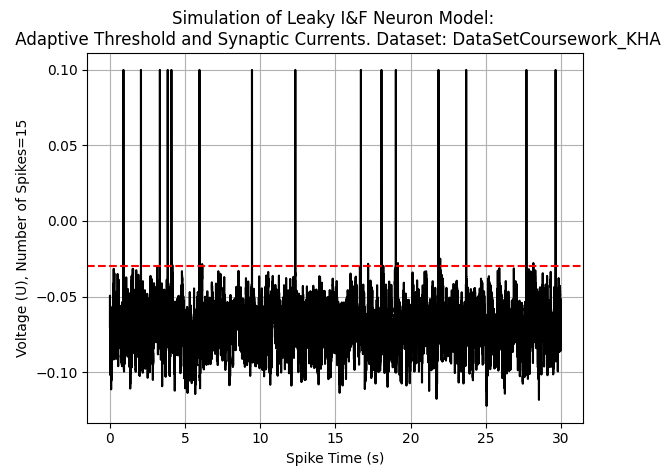

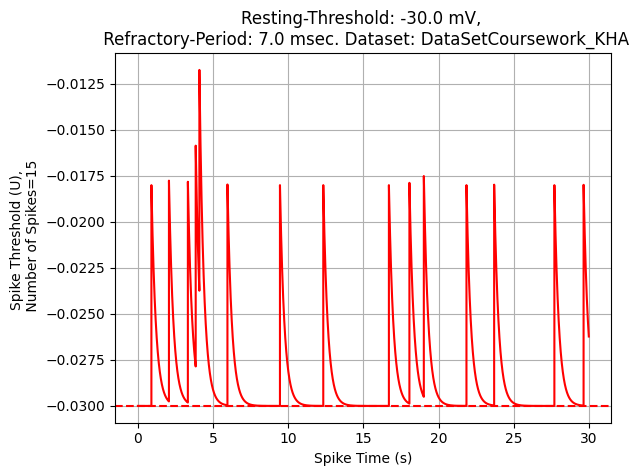

[-0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03

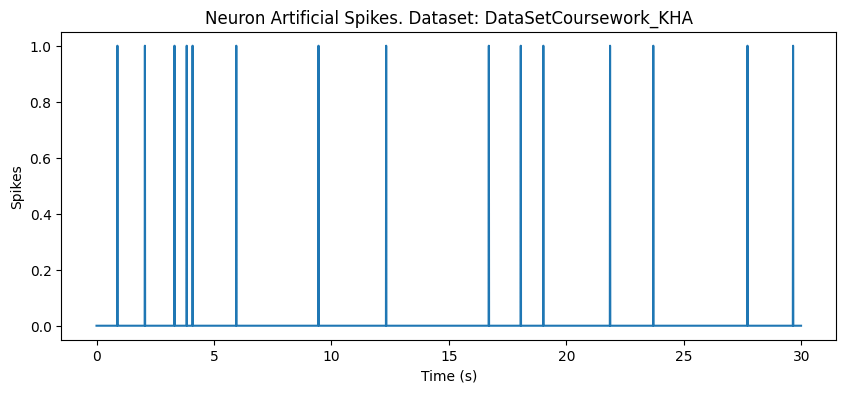

In [ ]:
# --- Generating post-synaptic currents from Neuron 4 ---

# Extract spike times from the fourth column of the 'spikes' array
spike_data = list(spikes[:, 0])

# Create a list to store PSC times
time = []

# Iterate through spike times and add corresponding times to 'time' list if a spike occurred
for spike_time in range(len(spike_data)):
    if spike_data[spike_time] != 0:
        time.append((spike_time + 1) * 0.01)  # Assuming time resolution of 0.01 seconds

# Prepare input currents dictionary
input_currents = {
    'psc': time,  # Excitatory post-synaptic current (PSC) times
    'U_0': 0.3,  # Reversal potential for PSCs
    'ipsc': np.array([0.03, 0.07]),  # Inhibitory post-synaptic current (IPSC) times
}

# --- Simulate the neuron model ---

# Call the leaky integrate-and-fire (LIF) model function to run the simulation
time, theta_adapt = LeakyIF_artificial_spikes(
    current_parameters=input_currents, dur=30, delta_t=0.001
)

# Print simulation results
print(list(theta_adapt))  # Print the adaptive threshold values over time
print(list(time))  # Print the time values for the simulation

artificial_spike4 = plot_artificial_spikes(time, theta_adapt, 0.001, 30)


# Artificial Spikes for Neuron-5

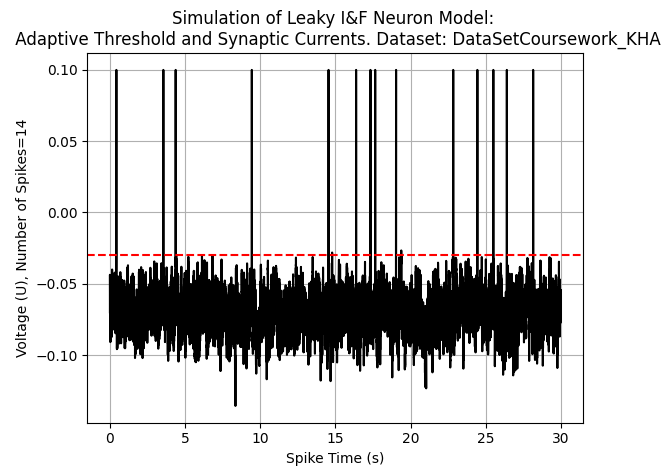

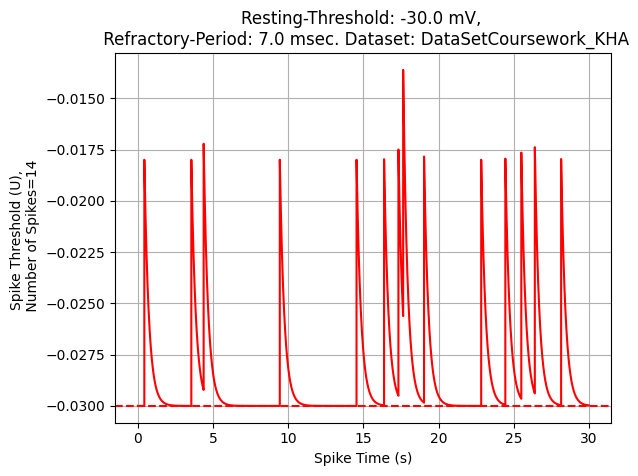

[-0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03

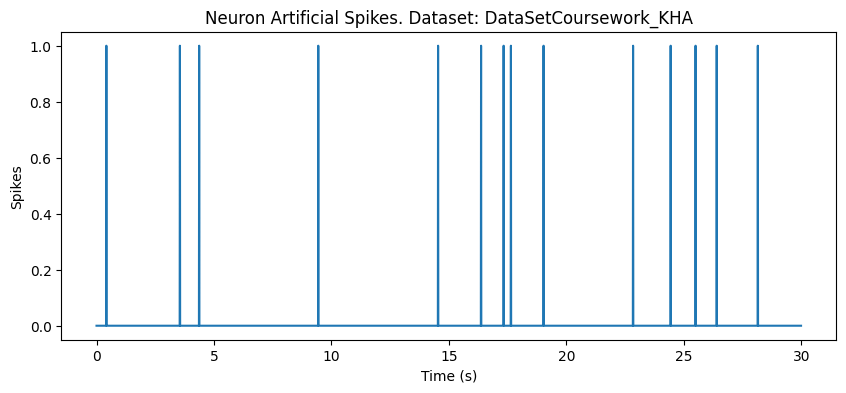

In [ ]:

# --- Generating post-synaptic currents from Neuron 5 ---

# Extract spike times from the fifth column of the 'spikes' array
spike_data = list(spikes[:, 0])

# Create a list to store PSC times
time = []

# Iterate through spike times and add corresponding times to 'time' list if a spike occurred
for spike_time in range(len(spike_data)):
    if spike_data[spike_time] != 0:
        time.append((spike_time + 1) * 0.01)  # Assuming time resolution of 0.01 seconds

# Prepare input currents dictionary
input_currents = {
    'psc': time,  # Excitatory post-synaptic current (PSC) times
    'U_0': 0.3,  # Reversal potential for PSCs
    'ipsc': np.array([0.03, 0.07]),  # Inhibitory post-synaptic current (IPSC) times
}

# --- Simulate the neuron model ---

# Call the leaky integrate-and-fire (LIF) model function to run the simulation
time, theta_adapt = LeakyIF_artificial_spikes(
    current_parameters=input_currents, dur=30, delta_t=0.001
)

# Print simulation results
print(list(theta_adapt))  # Print the adaptive threshold values over time
print(list(time))  # Print the time values for the simulation

artificial_spike5 = plot_artificial_spikes(time, theta_adapt, 0.001, 30)

# Artificial Spikes for Neuron-6

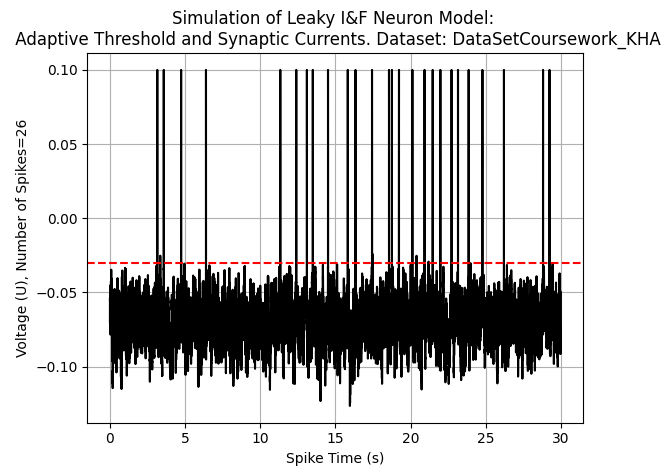

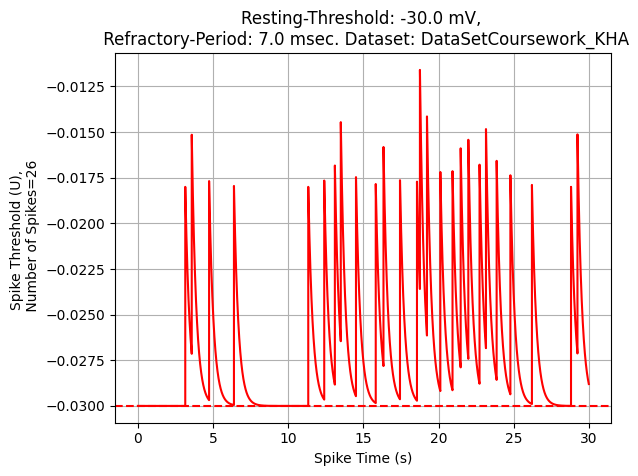

[-0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0.03

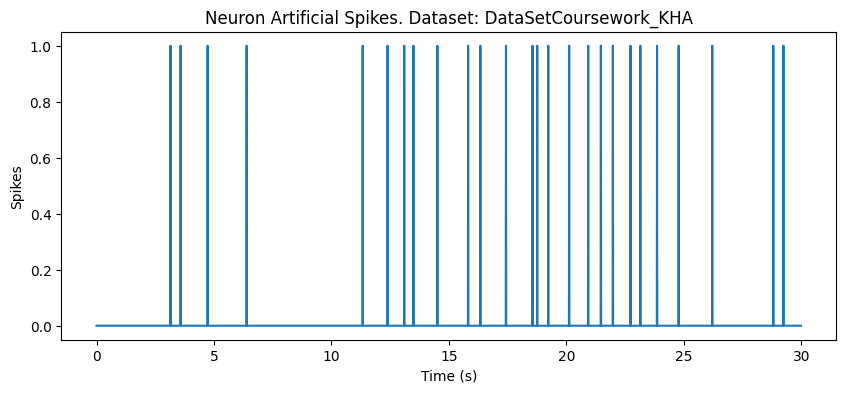

In [ ]:
# --- Generating post-synaptic currents from Neuron 6 ---

# Extract spike times from the sixth column of the 'spikes' array
spike_data = list(spikes[:, 0])

# Create a list to store PSC times
time = []

# Iterate through spike times and add corresponding times to 'time' list if a spike occurred
for spike_time in range(len(spike_data)):
    if spike_data[spike_time] != 0:
        time.append((spike_time + 1) * 0.01)  # Assuming time resolution of 0.01 seconds

# Prepare input currents dictionary
input_currents = {
    'psc': time,  # Excitatory post-synaptic current (PSC) times
    'U_0': 0.3,  # Reversal potential for PSCs
    'ipsc': np.array([0.03, 0.07]),  # Inhibitory post-synaptic current (IPSC) times
}

# --- Simulate the neuron model ---

# Call the leaky integrate-and-fire (LIF) model function to run the simulation
time, theta_adapt = LeakyIF_artificial_spikes(
    current_parameters=input_currents, dur=30, delta_t=0.001
)

# Print simulation results
print(list(theta_adapt))  # Print the adaptive threshold values over time
print(list(time))  # Print the time values for the simulation

artificial_spike6 = plot_artificial_spikes(time, theta_adapt, 0.001, 30)

Spikes and Firing Rates plot for-DataSetCoursework_KHA


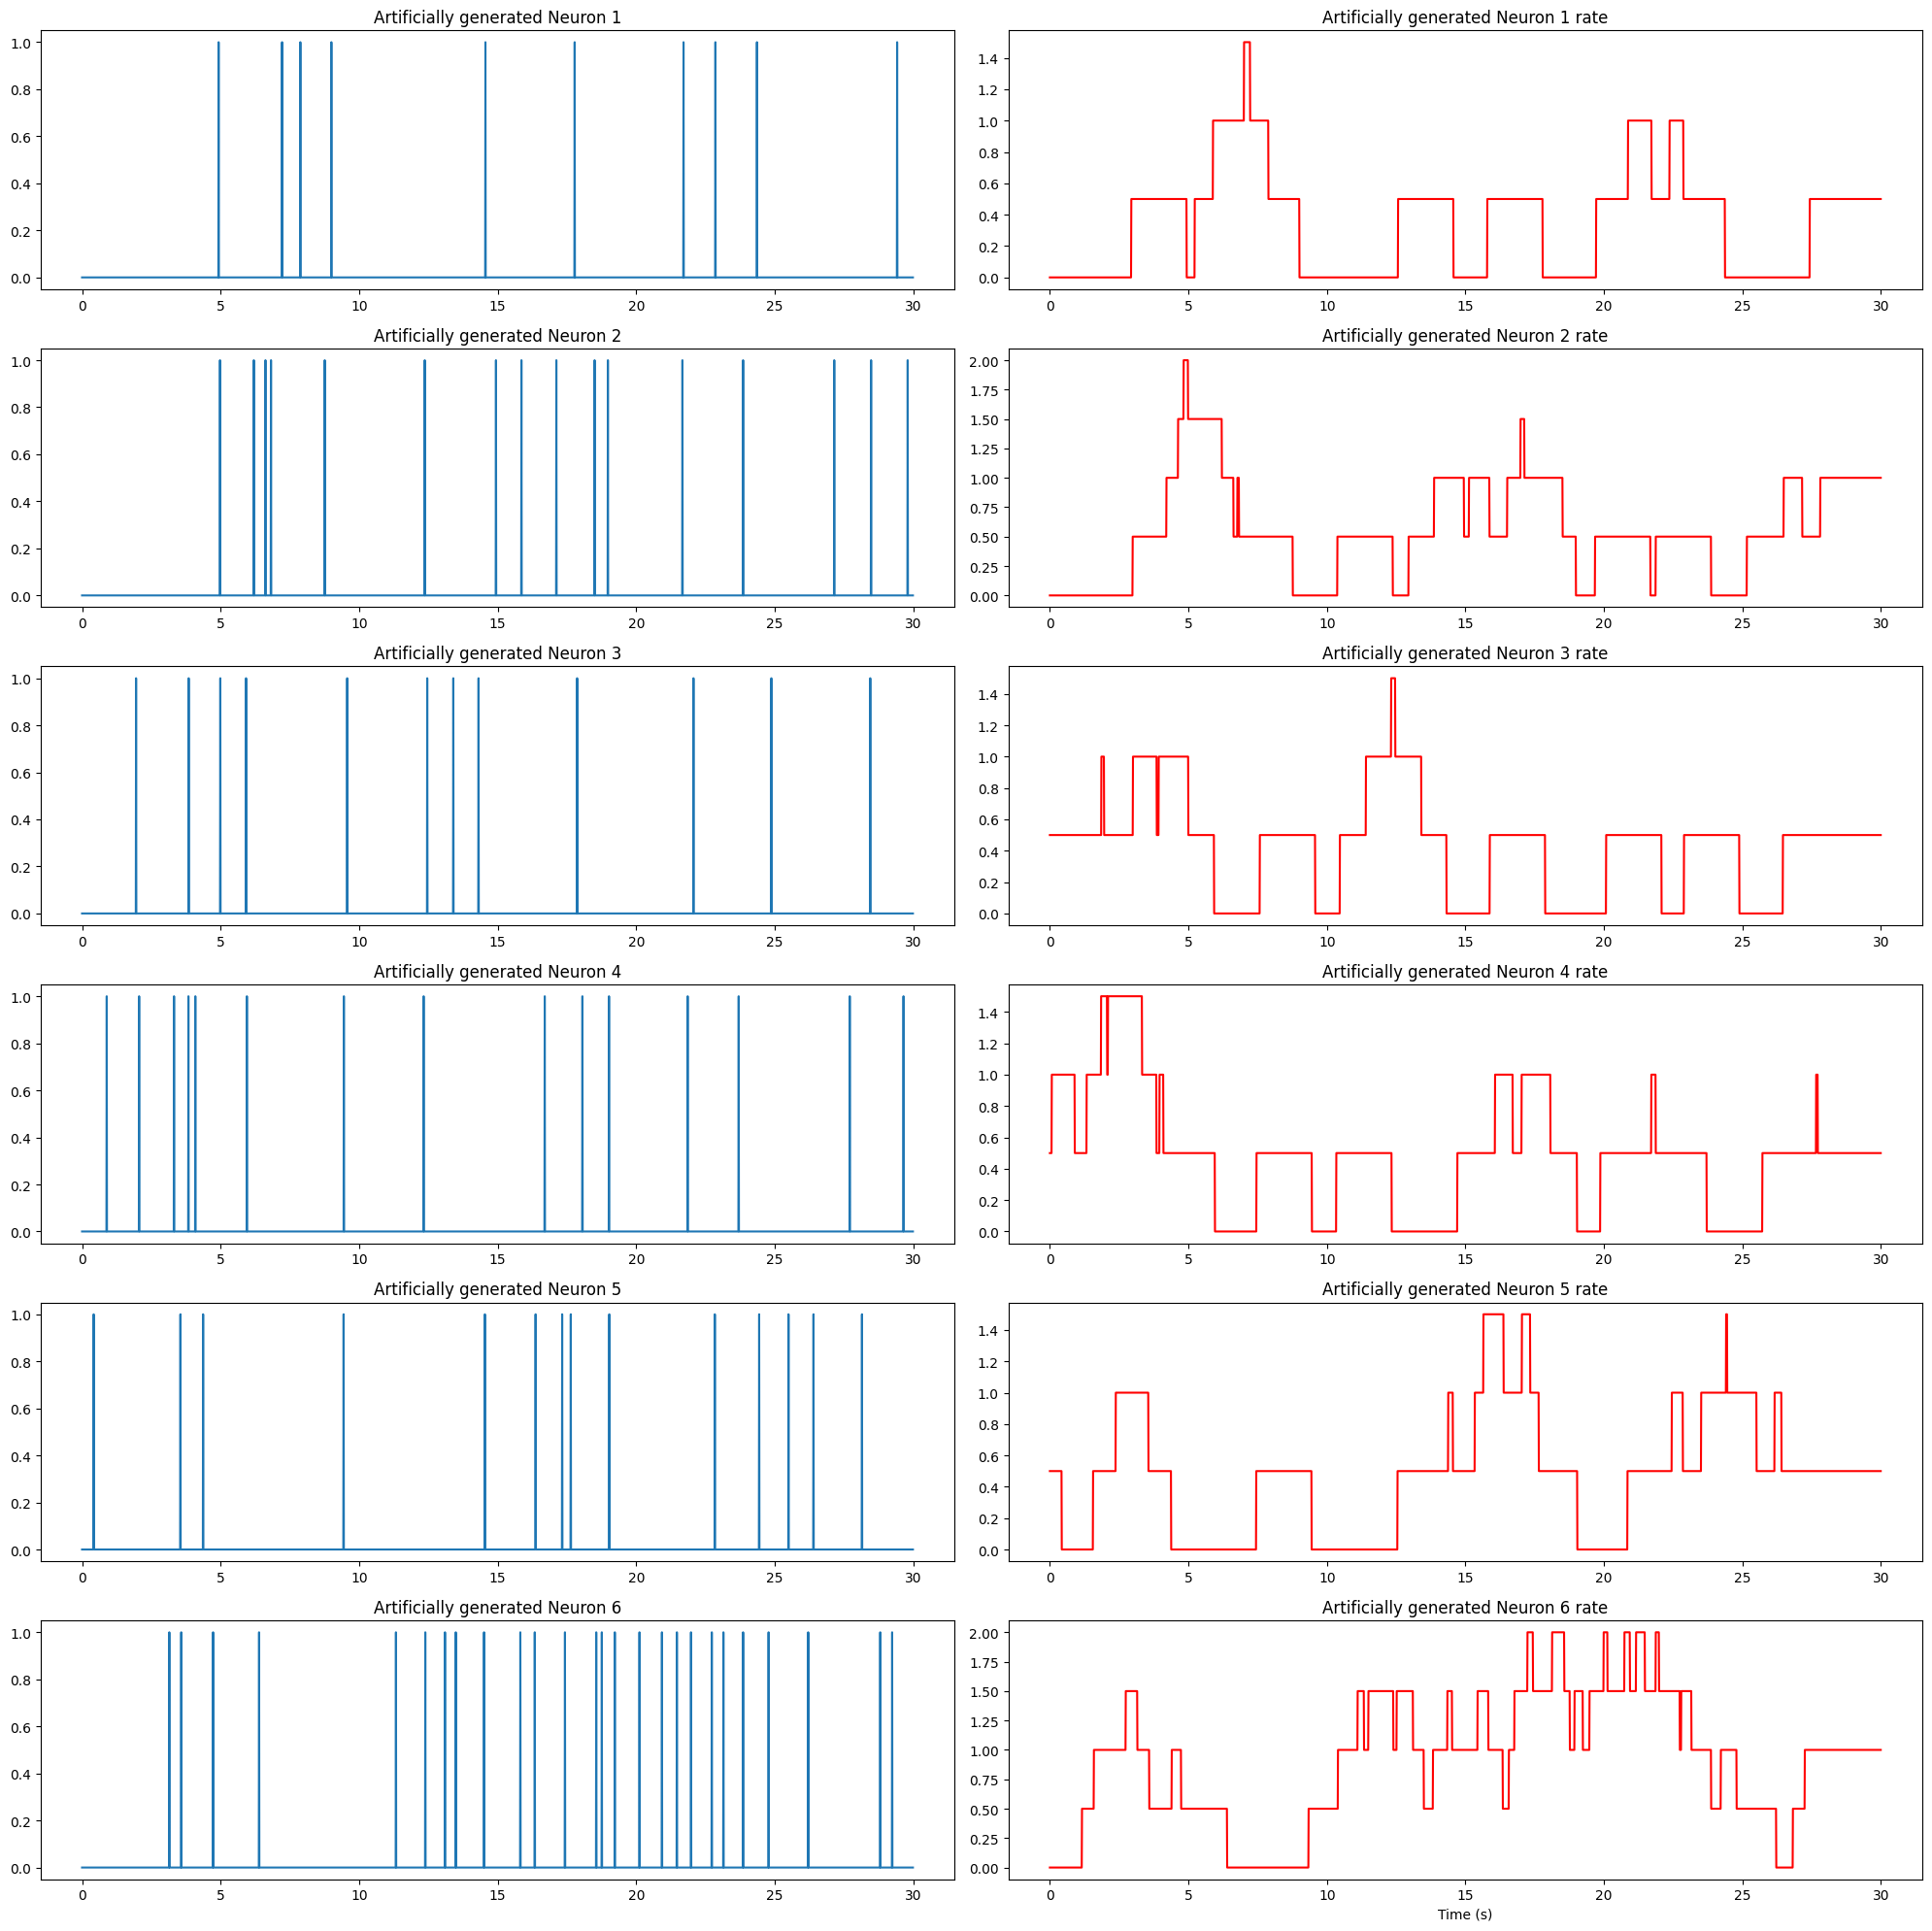

array([[0. , 0. , 0.5, ..., 0.5, 0. , 0. ],
       [0. , 0. , 0.5, ..., 0.5, 0. , 0. ],
       [0. , 0. , 0.5, ..., 0.5, 0. , 0. ],
       ...,
       [0.5, 1. , 0.5, ..., 0.5, 1. , 0. ],
       [0.5, 1. , 0.5, ..., 0.5, 1. , 0. ],
       [0.5, 1. , 0.5, ..., 0.5, 1. , 0. ]])

In [ ]:
artificial_spikes = np.transpose(np.array([artificial_spike1, artificial_spike2, artificial_spike3, artificial_spike4, artificial_spike5, artificial_spike6]), axes = None)
cal_rates(artificial_spikes, artificial_spikes=True)

#**Decoding**

### Importing all required libraries for Decoding

In [ ]:
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
import numpy as np
from sklearn.model_selection import cross_val_predict

###Exploring Data

In [ ]:
#Print first 1o rows of the dataset for analysis
first_10_rows = data[:10, :]
print(first_10_rows)

[[0. 0. 0. 0. 0. 0. 4. 1.]
 [0. 0. 0. 0. 0. 0. 4. 1.]
 [0. 0. 0. 0. 0. 0. 4. 1.]
 [0. 0. 0. 0. 0. 0. 4. 1.]
 [0. 0. 0. 0. 0. 0. 4. 1.]
 [0. 0. 0. 0. 0. 0. 4. 1.]
 [0. 0. 0. 0. 0. 0. 4. 1.]
 [0. 0. 0. 0. 0. 0. 4. 1.]
 [0. 0. 0. 0. 0. 0. 4. 1.]
 [0. 0. 0. 0. 0. 0. 4. 1.]]


### Extracting the required data

In [ ]:
new_ds = data[:, :-1]  # Extracts all rows and all columns except the last one

# Display the first 10 rows of the modified array
print(new_ds[:10])

[[0. 0. 0. 0. 0. 0. 4.]
 [0. 0. 0. 0. 0. 0. 4.]
 [0. 0. 0. 0. 0. 0. 4.]
 [0. 0. 0. 0. 0. 0. 4.]
 [0. 0. 0. 0. 0. 0. 4.]
 [0. 0. 0. 0. 0. 0. 4.]
 [0. 0. 0. 0. 0. 0. 4.]
 [0. 0. 0. 0. 0. 0. 4.]
 [0. 0. 0. 0. 0. 0. 4.]
 [0. 0. 0. 0. 0. 0. 4.]]


### Preparing the data for model's training

In [ ]:
X = new_ds[:, :-1]  # Extracts all rows and all columns except the last one
Y = new_ds[:, -1]   # Extracts all rows from the last column (target variable)

# Check shapes to verify correctness
print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

Shape of X: (2977, 6)
Shape of Y: (2977,)


## Evaluating the performance of the model

### Training Model and using 5-Fold cross validation technique for evaluation (where; input= spikes)

5-Fold Cross-Validation Accuracy: 0.5169633859590191
Confusion Matrix:
[[   0    3    5  208]
 [   0   28   22  548]
 [   0   17   43  605]
 [   0    7   23 1468]]


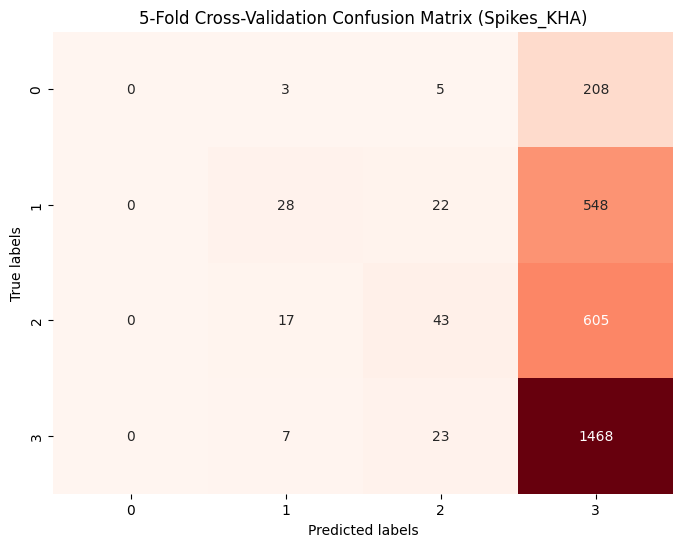

In [ ]:
# Assuming X contains input features and Y contains target labels

# Initializing SVM model
svm_classifier = SVC(kernel='rbf', gamma='scale')

# Number of folds (k = 5)
num_folds = 5

# Initializing KFold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Performing KFold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    # Fit the classifier on the training data
    svm_classifier.fit(X_train, y_train)

    # Model's Prediction on the test data
    y_pred = svm_classifier.predict(X_test)

    # Collect true and predicted labels
    true_labels.extend(y_test)
    predicted_labels.extend(y_pred)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("5-Fold Cross-Validation Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Reds', fmt='d', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('5-Fold Cross-Validation Confusion Matrix (Spikes_KHA)')
plt.show()

### Training Model and using 20-Fold cross validation technique for evaluation (where; input= spikes)

20-Fold Cross-Validation Accuracy: 0.5159556600604636
Confusion Matrix:
[[   0    1    7  208]
 [   0   31   24  543]
 [   0   21   41  603]
 [   0   11   23 1464]]


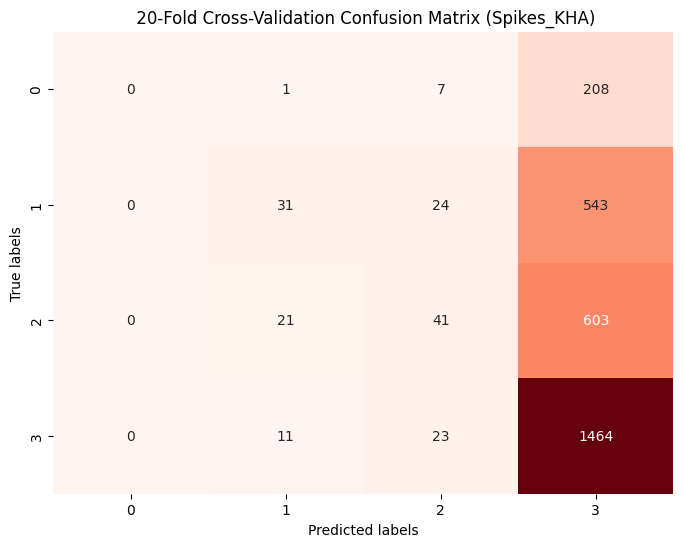

In [ ]:
# Assuming X contains input features and Y contains target labels

# Initializing SVM model
svm_classifier = SVC(kernel='rbf', gamma='scale')

# Number of folds (k = 20)
num_folds = 20

# Initializing KFold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Performing KFold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    # Fit the classifier on the training data
    svm_classifier.fit(X_train, y_train)

    # Model's Prediction on the test data
    y_pred = svm_classifier.predict(X_test)

    # Collect true and predicted labels
    true_labels.extend(y_test)
    predicted_labels.extend(y_pred)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("20-Fold Cross-Validation Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Reds', fmt='d', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(' 20-Fold Cross-Validation Confusion Matrix (Spikes_KHA)')
plt.show()

### Using Leave-One-Out crossvalidation (input = spikes) (Time Consuming)

SVM Confusion Matrix:
[[   0    1    7  208]
 [   0   38   24  536]
 [   0   24   41  600]
 [   0   11   25 1462]]
Decision Tree Confusion Matrix:
[[   0    3    5  208]
 [   0   39   23  536]
 [   0   25   40  600]
 [   0   14   22 1462]]

SVM Accuracy: 0.5176352032247229
Decision Tree Accuracy: 0.5176352032247229


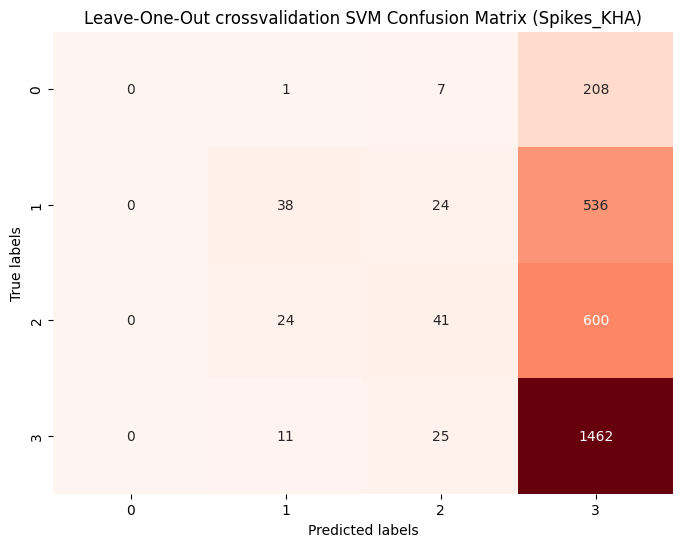

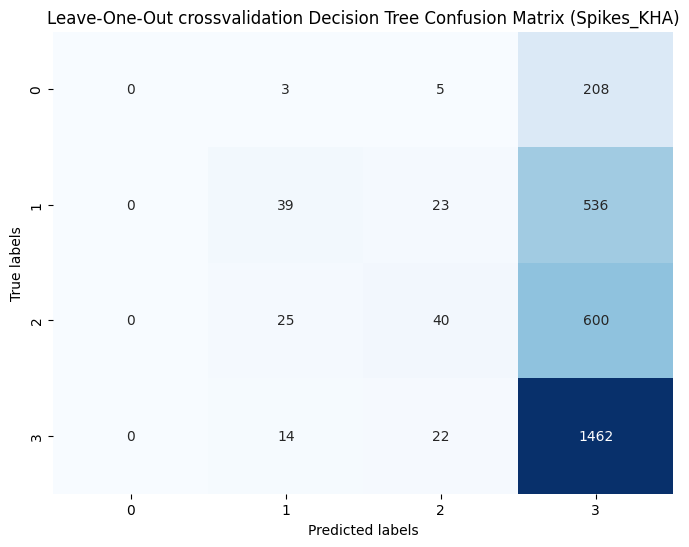

In [ ]:
# Assuming X contains input features and Y contains target labels

scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# SVM classifier with RBF kernel
svm_classifier = SVC(kernel='rbf', gamma='scale')  # 'gamma' can be 'scale' for auto-determination

# Decision Tree classifier
dt_classifier = DecisionTreeClassifier()

# Train the SVM classifier
svm_classifier.fit(X_standardized, Y)

# Perform leave-one-out cross-validation with SVM
loo = LeaveOneOut()
svm_cross_val_results = cross_val_predict(svm_classifier, X_standardized, Y, cv=loo)

# Train Decision Tree classifier
dt_classifier.fit(X_standardized, Y)

# Perform leave-one-out cross-validation with Decision Tree
dt_cross_val_results = cross_val_predict(dt_classifier, X_standardized, Y, cv=loo)

# Calculate accuracy scores for SVM and Decision Tree
svm_accuracy = accuracy_score(Y, svm_cross_val_results)
dt_accuracy = accuracy_score(Y, dt_cross_val_results)


# Calculate confusion matrix for SVM
svm_conf_matrix = confusion_matrix(Y, svm_cross_val_results)
print("SVM Confusion Matrix:")
print(svm_conf_matrix)

# Calculate confusion matrix for Decision Tree
dt_conf_matrix = confusion_matrix(Y, dt_cross_val_results)
print("Decision Tree Confusion Matrix:")
print(dt_conf_matrix)
print("\nSVM Accuracy:", svm_accuracy)
print("Decision Tree Accuracy:", dt_accuracy)



# Plotting the heatmap for SVM Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(svm_conf_matrix, annot=True, cmap='Reds', fmt='d', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Leave-One-Out crossvalidation SVM Confusion Matrix (Spikes_KHA)')
plt.show()

# Plotting the heatmap for Decision Tree Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(dt_conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Leave-One-Out crossvalidation Decision Tree Confusion Matrix (Spikes_KHA)')
plt.show()


### Performing analysis on firing rates data

In [ ]:
# Display the first 10 rows of the rates
print(rates[:10])  # Use array slicing to display the first 10 rows

print("----"*8)

# Display the last 10 rows of the rates
print(rates[-10:])

[[0.5 0.5 0.  1.  3.5 3.  0. ]
 [0.5 0.5 0.  1.  3.5 3.  0. ]
 [0.5 0.5 0.  1.  3.5 3.  0. ]
 [0.5 0.5 0.  1.  3.5 3.  0. ]
 [0.5 0.5 0.  1.  3.5 3.  0. ]
 [0.5 0.5 0.  1.  3.5 3.  0. ]
 [0.5 0.5 0.  1.  3.5 3.  0. ]
 [0.5 0.5 0.  1.  3.5 3.  0. ]
 [0.5 0.5 0.  1.  3.5 3.  0. ]
 [0.5 0.5 0.  1.  3.5 3.  0. ]]
--------------------------------
[[1.  1.  3.  0.5 2.  1.5 0. ]
 [1.  1.  3.  0.5 2.  1.5 0. ]
 [1.  1.  3.  0.5 2.  1.5 0. ]
 [1.  1.  3.  0.5 2.  1.5 0. ]
 [1.  1.  3.  0.5 2.  1.5 0. ]
 [1.  1.  3.  0.5 2.  1.5 0. ]
 [1.  1.  3.  0.5 2.  1.5 0. ]
 [1.  1.  3.  0.5 2.  1.5 0. ]
 [1.  1.  3.  0.5 2.  1.5 0. ]
 [1.  1.  3.  0.5 2.  1.5 0. ]]


### Preparing the data for model's training

In [ ]:
X = rates
Y = behaviours

# Check shapes to verify correctness
print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

Shape of X: (2977, 7)
Shape of Y: (2977,)


### Evaluating the model's performance using 20 percent test data

In [ ]:
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialize an SVM classifier
svm_classifier = SVC(kernel='linear')

# Train the classifier on the training data
svm_classifier.fit(X_train, Y_train)

# Predicton of the trained model on the test data
Y_pred = svm_classifier.predict(X_test)

# Calculate accuracy for the predictions
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7835570469798657


### Training Model and using 5-Fold cross validation technique for evaluation (where; input= Firing rates)

Average accuracy across 5-fold cross-validation: 0.39667193051717337
Confusion Matrix:
[[  0   0   0 216]
 [ 44  84 419  51]
 [109 269 231  56]
 [459  71 102 866]]


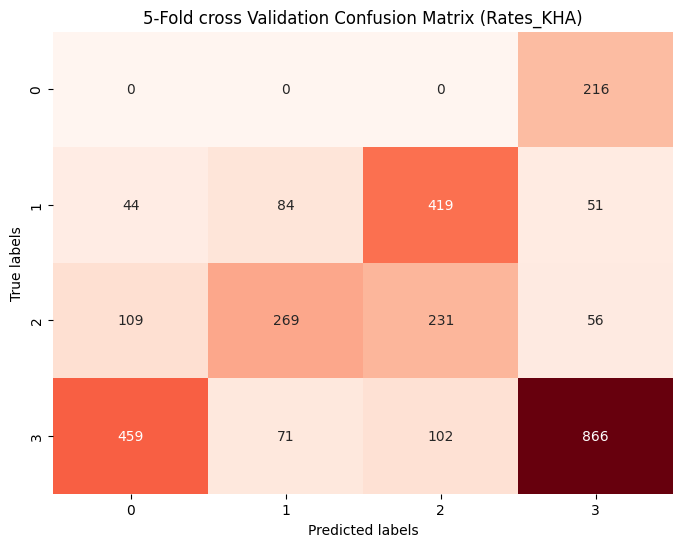

In [ ]:
# Assuming X contains input features and Y contains target labels

# Initialize an SVM classifier
svm_classifier = SVC(kernel='linear')

# Perform 5-fold cross-validation
num_folds = 5
kf = KFold(n_splits=num_folds)

fold_accuracies = []
all_y_true = []
all_y_pred = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    # Train the classifier on the training data
    svm_classifier.fit(X_train, Y_train)

    # Predict using the trained model on the test data
    Y_pred = svm_classifier.predict(X_test)

    # Store true and predicted values for each fold
    all_y_true.extend(Y_test)
    all_y_pred.extend(Y_pred)

    # Calculate accuracy for the predictions
    accuracy = accuracy_score(Y_test, Y_pred)
    fold_accuracies.append(accuracy)

# Calculate average accuracy across all folds
average_accuracy = np.mean(fold_accuracies)
print(f"Average accuracy across {num_folds}-fold cross-validation: {average_accuracy}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_y_true, all_y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Reds', fmt='d', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('5-Fold cross Validation Confusion Matrix (Rates_KHA)')
plt.show()


### Training Model and using 20-Fold cross validation technique for evaluation (where; input= Firing rates)

Average accuracy across 20-fold cross-validation: 0.5854434971884637
Confusion Matrix:
[[   0    0    0  216]
 [  33  327  164   74]
 [   0  189  242  234]
 [  18   83  223 1174]]


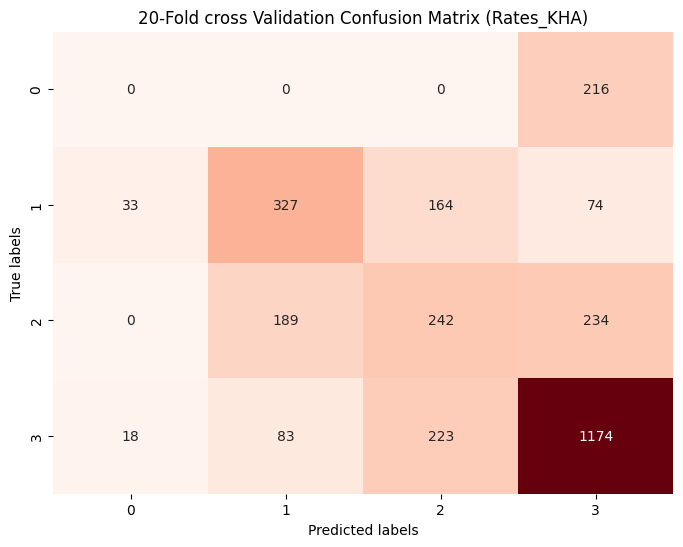

In [ ]:
# Assuming X contains input features and Y contains target labels

# Initialize an SVM classifier
svm_classifier = SVC(kernel='linear')

# Perform 20-fold cross-validation
num_folds = 20
kf = KFold(n_splits=num_folds)

fold_accuracies = []
all_y_true = []
all_y_pred = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    # Train the classifier on the training data
    svm_classifier.fit(X_train, Y_train)

    # Predict using the trained model on the test data
    Y_pred = svm_classifier.predict(X_test)

    # Store true and predicted values for each fold
    all_y_true.extend(Y_test)
    all_y_pred.extend(Y_pred)

    # Calculate accuracy for the predictions
    accuracy = accuracy_score(Y_test, Y_pred)
    fold_accuracies.append(accuracy)

# Calculate average accuracy across all folds
average_accuracy = np.mean(fold_accuracies)
print(f"Average accuracy across {num_folds}-fold cross-validation: {average_accuracy}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_y_true, all_y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Reds', fmt='d', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('20-Fold cross Validation Confusion Matrix (Rates_KHA)')
plt.show()


### Using Leave-One-Out crossvalidation (input = Firing Rate) (Time Consuming)

SVM Confusion Matrix:
[[ 166    1    0   49]
 [  13  567   12    6]
 [   0   33  519  113]
 [   1   26    2 1469]]

Decision Tree Confusion Matrix:
[[ 193    1    0   22]
 [   5  584    5    4]
 [   0    1  661    3]
 [  20    3   96 1379]]

SVM Accuracy: 0.9140073899899227
Decision Tree Accuracy: 0.9462546187437018


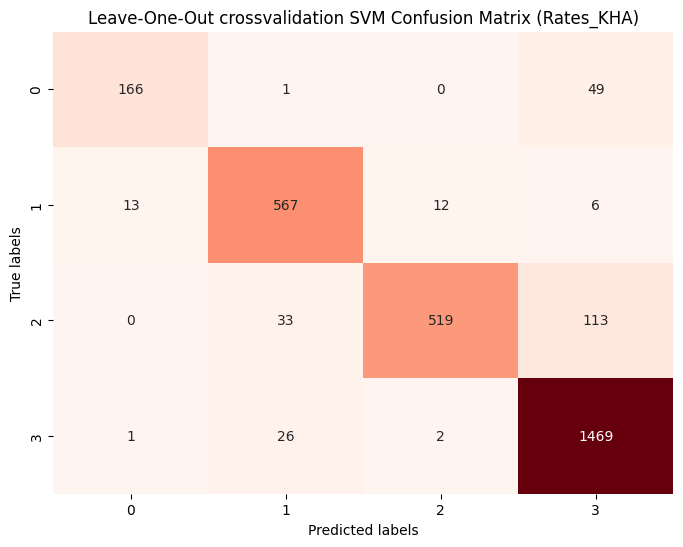

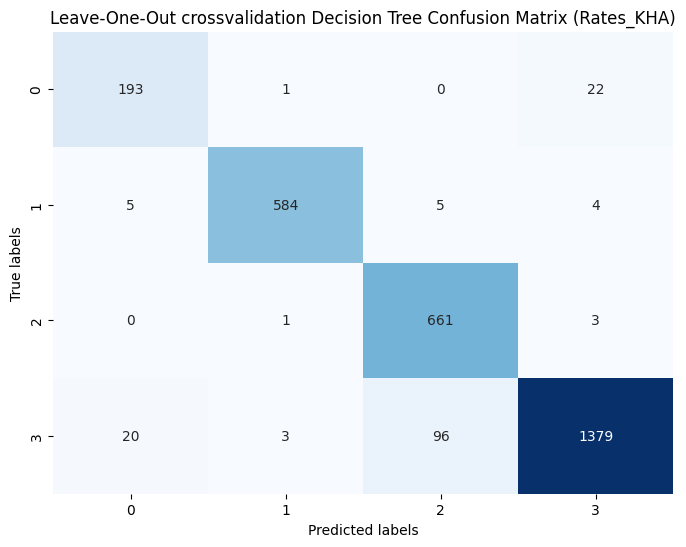

In [ ]:
# Assuming X contains input features and Y contains target labels

scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# SVM classifier with RBF kernel
svm_classifier = SVC(kernel='rbf', gamma='scale')  # 'gamma' is 'scale' for auto-determination

# Decision Tree classifier
dt_classifier = DecisionTreeClassifier()

# Perform leave-one-out cross-validation and get predicted labels for SVM
loo = LeaveOneOut()
svm_cross_val_results = cross_val_predict(svm_classifier, X_standardized, Y, cv=loo)

# Perform leave-one-out cross-validation and get predicted labels for Decision Tree
dt_cross_val_results = cross_val_predict(dt_classifier, X_standardized, Y, cv=loo)

# Calculate confusion matrix for SVM
svm_conf_matrix = confusion_matrix(Y, svm_cross_val_results)

# Calculate confusion matrix for Decision Tree
dt_conf_matrix = confusion_matrix(Y, dt_cross_val_results)

# Calculate accuracy scores for SVM and Decision Tree
svm_accuracy = accuracy_score(Y, svm_cross_val_results)
dt_accuracy = accuracy_score(Y, dt_cross_val_results)

# Print confusion matrices
print("SVM Confusion Matrix:")
print(svm_conf_matrix)
print("\nDecision Tree Confusion Matrix:")
print(dt_conf_matrix)
print("\nSVM Accuracy:", svm_accuracy)
print("Decision Tree Accuracy:", dt_accuracy)

# Plotting the heatmap for SVM Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(svm_conf_matrix, annot=True, cmap='Reds', fmt='d', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Leave-One-Out crossvalidation SVM Confusion Matrix (Rates_KHA)')
plt.show()

# Plotting the heatmap for Decision Tree Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(dt_conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Leave-One-Out crossvalidation Decision Tree Confusion Matrix (Rates_KHA)')
plt.show()
